# Analisis de framing para bases de datos

In [110]:
# Librerías a utilizar

# Análisis de datos
import pandas as pd
pd.options.display.max_columns = None
import re
import numpy as np
import seaborn as sns
import networkx as nx

# Análisis de contenido 
import spacy
# !python -m spacy download es_core_news_md  # Modelo mediano (recomendado) (de preferencia instalar en terminal)
# Carga el modelo en español
nlp = spacy.load("es_core_news_md")
from collections import Counter
from transformers import pipeline


In [111]:
# Cargando las cuatro bases de datos
# La Voz del Sur
la_voz_del_sur = pd.read_csv('analisis/analisis_vozdelsur.csv')
# Letra Fría
letra_fria = pd.read_csv('analisis/analisis_letrafria.csv')

# Al Calor Político
al_calor_politico = pd.read_csv('analisis/analisis_alcalorpolitico.csv')
# Plumas Libres
plumas_libres = pd.read_csv('analisis/analisis_plumaslibres.csv')

In [112]:
# Primero: combinar los databases en uno

# Asumiendo que ya tienes cargados tus 4 DataFrames
# Si no, primero carga cada uno con pd.read_csv()

# Añadir columna 'medio' a cada DataFrame
la_voz_del_sur['medio'] = 'La Voz del Sur'
letra_fria['medio'] = 'Letra Fría'
al_calor_politico['medio'] = 'Al Calor Político'
plumas_libres['medio'] = 'Plumas Libres'

# Combinar los DataFrames
df = pd.concat([
    la_voz_del_sur,
    letra_fria,
    al_calor_politico,
    plumas_libres
], ignore_index=True)

# Verificar
print(df['medio'].value_counts())

medio
Al Calor Político    1344
La Voz del Sur       1056
Letra Fría            602
Plumas Libres         469
Name: count, dtype: int64


In [113]:
df

,titulo,articulo,lugar,tags,contiene_ES,fecha,url,analisis,sentimiento,medio,autor,longitud,fecha_limpia
0,Dan Banderazo de Arranque al Operativo de Sema...,*Autoridades de los tres niveles de gobierno t...,NaN,"Chava Zamora, jalisco, la voz del sur de jalis...",no,"abril 12th, 2025",https://www.lavozdelsur.com.mx/dan-banderazo-d...,"{'entidades': [('UEPCBJ', 'ORG'), ('Puesto de ...",NEU,La Voz del Sur,NaN,NaN,NaN
1,La Falta de Vigilancia en las Carreteras,"Sin duda alguna, los recientes cierres en las ...",NaN,"autopistas, Ciudad Guzmán, Falta de Agua, Oper...",no,"abril 11th, 2025",https://www.lavozdelsur.com.mx/la-falta-de-vig...,"{'entidades': [('Sur de Jalisco', 'LOC'), ('Se...",NEG,La Voz del Sur,NaN,NaN,NaN
2,Banda Real de la Montaña Lleva su Música al Fe...,Las potentes y muy alegres notas del estilo mu...,NaN,"Cultura, La Vos del Sur, Múscia Regional Mexic...",no,"abril 11th, 2025",https://www.lavozdelsur.com.mx/banda-real-de-l...,"{'entidades': [('Minatitlán', 'LOC'), ('Veracr...",POS,La Voz del Sur,NaN,NaN,NaN
3,Muere un Hombre Atropellado en la Autopista Gu...,", (ES).- Intensa movilización de unidades de e...","GÓMEZ FARÍAS, JAL.","autopista, Ciuadad Guzmán, GómezFarías, muerto...",yes,"abril 10th, 2025",https://www.lavozdelsur.com.mx/muere-un-hombre...,"{'entidades': [('ES).-', 'LOC'), ('Autopista G...",NEU,La Voz del Sur,NaN,NaN,NaN
4,Conforman Ayuntamiento Infantil 2025 Frente Au...,(ES).- El Gobierno Municipal de Zapotlán el Gr...,"CIUDAD GUZMÁN, JAL.","Ayuntamiento Infantil de Zapotlán, Cabildo Inf...",yes,"abril 9th, 2025",https://www.lavozdelsur.com.mx/conforman-ayunt...,"{'entidades': [('ES).-', 'LOC'), ('Gobierno Mu...",NEU,La Voz del Sur,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466,Protestan en Ixtaczoquitlán porque el Ayuntami...,"Manuela V. CarmonaIxtaczoquitlán, Ver.- Habita...",NaN,NaN,NaN,11 Ene 24,https://plumaslibres.com.mx/2024/01/11/protest...,{'entidades': [('Manuela V. CarmonaIxtaczoquit...,NaN,Plumas Libres,"Manuela V. CarmonaIxtaczoquitlán, Ver.- Habita...",NaN,NaN
3467,Prevén hoy Surada en el sur y la masa de aire ...,"Xalapa, Ver.El frente frío 26 recorre con rapi...",NaN,NaN,NaN,12 Ene 24,https://plumaslibres.com.mx/2024/01/12/preven-...,"{'entidades': [('Xalapa', 'LOC'), ('El frente ...",NaN,Plumas Libres,"Xalapa, Ver.El frente frío 26 recorre con rapi...",NaN,NaN
3468,"Por efecto de la pandemia en México, 250 mil n...",Pascacio Taboada Cortina/Jorge Martínez Cedill...,NaN,NaN,NaN,6 Feb 24,https://plumaslibres.com.mx/2024/02/06/por-efe...,"{'entidades': [('Pascacio Taboada Cortina', 'P...",NaN,Plumas Libres,Pascacio Taboada Cortina/Jorge Martínez Cedillo,NaN,NaN
3469,Tramita amparo ex vocera de Javier Duarte para...,"Xalapa, Ver.- Con fecha 23 de enero de este añ...",NaN,NaN,NaN,27 Ene 24,https://plumaslibres.com.mx/2024/01/27/tramita...,"{'entidades': [('Xalapa', 'LOC'), ('Ver.-', 'L...",NaN,Plumas Libres,"Xalapa, Ver.- Con fecha 23 de enero de este añ...",NaN,NaN


In [114]:


# Cargar el modelo de spaCy (asegúrate de tener el mismo que usaste para procesar)


# Convertir las columnas de análisis de string a diccionario
df['analisis'] = df['analisis'].apply(lambda x: eval(x) if pd.notnull(x) else {})

In [115]:


# Listas de palabras a excluir (puedes ampliar estas listas)
palabras_a_filtrar = {
    'entidades': ['Jalisco', 'México', 'Guadalajara', 'Colima', 'Autlán', 'Xalapa', 'Veracruz', 'Ciudad Guzmán', 
                 'Tecolotlán', 'El Grullo', 'Cihuatlán', 'Zapotlán', 'Zapotiltic', 'Limón'],
    'stopwords': ['través', 'el', 'parte', 'gobierno', 'municipal', 'tema', 'personas', 'Fin area', 'Fin Texto', 'Veracruz', 'municipio', 'ES).-']
}

# Alternativa: usar las entidades ya identificadas en tu análisis
def get_entity_words(analisis_dict):
    return [ent[0].lower() for ent in analisis_dict.get('entidades', [])]

# Extraer todas las entidades únicas de tu dataset
all_entities = set()
for analisis in df['analisis']:
    all_entities.update(get_entity_words(analisis))
    
palabras_a_filtrar['entidades'] = list(all_entities)

In [ ]:
def filter_keywords(keywords, filter_words):
    """Filtra palabras clave que son entidades o lugares"""
    filtered = []
    for kw in keywords:
        kw_lower = kw.lower()
        # Excluir si es una entidad conocida o stopword
        if (kw_lower not in filter_words['entidades'] and 
            kw_lower not in filter_words['stopwords'] and
            len(kw) > 3):  # Excluir palabras muy cortas
            filtered.append(kw)
    return filtered

# Aplicar el filtro
df['filtered_keywords'] = df['analisis'].apply(
    lambda x: filter_keywords(x, palabras_a_filtrar))

In [117]:
# analisis de palabras clave filtradas
# Contar frecuencia de palabras clave filtradas
all_filtered_keywords = [kw for sublist in df['filtered_keywords'] for kw in sublist]
filtered_keyword_counts = Counter(all_filtered_keywords).most_common(30)

# Visualizar
plt.figure(figsize=(12, 8))
sns.barplot(x=[count[1] for count in filtered_keywords_counts], 
            y=[count[0] for count in filtered_keywords_counts])
plt.title("Palabras clave conceptuales más frecuentes (Frames relevantes)")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

NameError: name 'filtered_keywords_counts' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
#Enfoque basado en Parts of Speech
def conceptual_keywords(text, nlp):
    """Identifica palabras conceptuales basadas en POS tagging"""
    doc = nlp(text)
    conceptual_words = []
    
    for token in doc:
        # Filtrar sustantivos comunes, adjetivos, verbos (excluyendo nombres propios)
        if (token.pos_ in ['NOUN', 'ADJ', 'VERB'] and 
            token.ent_type_ not in ['LOC', 'ORG', 'PER', 'MISC'] and
            len(token.text) > 3 and
            not token.is_stop):
            conceptual_words.append(token.text.lower())
    
    return list(set(conceptual_words))  # Eliminar duplicados

# Aplicar a los títulos o textos (ajusta según tu estructura)
df['conceptual_keywords'] = df['titulo'].apply(lambda x: conceptual_keywords(x, nlp))

# Contar y visualizar
all_conceptual = [kw for sublist in df['conceptual_keywords'] for kw in sublist]
conceptual_counts = Counter(all_conceptual).most_common(30)

plt.figure(figsize=(12, 8))
sns.barplot(x=[count[1] for count in conceptual_counts], 
            y=[count[0] for count in conceptual_counts])
plt.title("Términos conceptuales más frecuentes en títulos")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

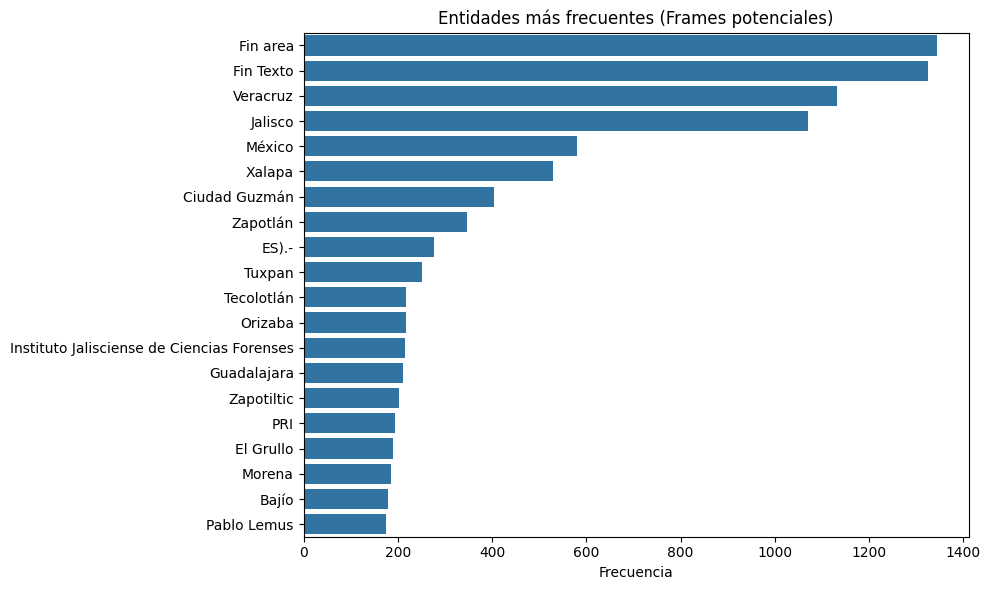

In [ ]:
import matplotlib.pyplot as plt
#import seaborn as sns
# analisis de FRames basado en entidades
def extract_entities(analisis_dict):
    return [ent[0] for ent in analisis_dict.get('entidades', [])]

df['entities'] = df['analisis'].apply(extract_entities)

# Contar frecuencia de entidades
all_entities = [ent for sublist in df['entities'] for ent in sublist]
entity_counts = Counter(all_entities).most_common(20)

# Visualizar
plt.figure(figsize=(10,6))
sns.barplot(x=[count[1] for count in entity_counts], 
            y=[count[0] for count in entity_counts])
plt.title("Entidades más frecuentes (Frames potenciales)")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

In [ ]:
all_entities

['UEPCBJ',
 'Puesto de Comando Central',
 'Jalisco',
 'Gobierno del Estado',
 'Operativo Interinstitucional',
 'Semana Santa',
 'Pascua 2025',
 'Jalisco',
 'Unidad Estatal de Protección Civil y Bomberos de Jalisco',
 'UEPCBJ',
 'Secretaría de Seguridad del Estado',
 'Policía Vial',
 'Secretaría de Medio Ambiente y Desarrollo Territorial',
 'Semadet',
 'Secretaría de Salud',
 'Servicio de Atención Médica de Urgencias',
 'SAMU',
 'Consejo Estatal para la Prevención de Accidentes',
 'Centro Histórico de Guadalajara',
 'Salvador Zamora Zamora',
 'Secretario General de Gobierno',
 'Sergio Ramírez López',
 'Director Estatal de Protección Civil y',
 'Bomberos de Jalisco',
 'Juan Pablo Hernández González',
 'Secretario de Seguridad Pública',
 'Estado de Jalisco',
 'Secretario General de Gobierno',
 'Pablo Lemus',
 'Gobernador de Jalisco',
 'Gobernador',
 'Jalisco',
 'Secretario General de Gobierno',
 'Zamora',
 'UEPCBJ',
 'Sergio Ramírez López',
 'Director General de Protección Civil y',
 'Bom

In [ ]:
entity_counts

[('Fin area', 1344),
 ('Fin Texto', 1326),
 ('Veracruz', 1133),
 ('Jalisco', 1070),
 ('México', 581),
 ('Xalapa', 530),
 ('Ciudad Guzmán', 403),
 ('Zapotlán', 347),
 ('ES).-', 276),
 ('Tuxpan', 252),
 ('Tecolotlán', 218),
 ('Orizaba', 217),
 ('Instituto Jalisciense de Ciencias Forenses', 215),
 ('Guadalajara', 211),
 ('Zapotiltic', 202),
 ('PRI', 195),
 ('El Grullo', 189),
 ('Morena', 186),
 ('Bajío', 179),
 ('Pablo Lemus', 175)]

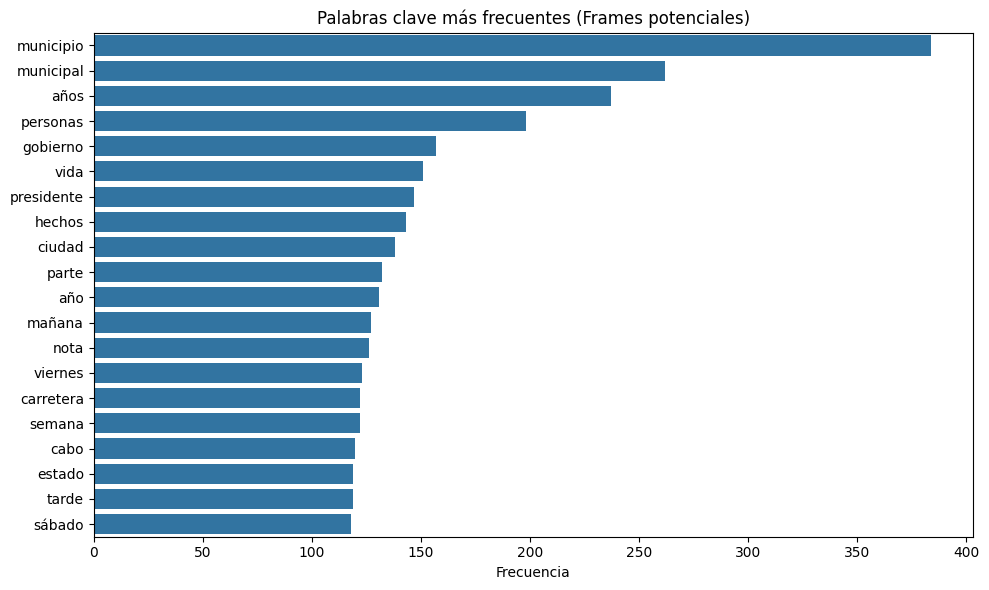

In [ ]:
# Análisisde de frames basado en Palabras clave
def extract_keywords(analisis_dict):
    return analisis_dict.get('palabras_clave', [])

df['keywords'] = df['analisis'].apply(extract_keywords)

# Contar frecuencia de palabras clave
all_keywords = [kw for sublist in df['keywords'] for kw in sublist]
keyword_counts = Counter(all_keywords).most_common(20)

# Visualizar
plt.figure(figsize=(10,6))
sns.barplot(x=[count[1] for count in keyword_counts], 
            y=[count[0] for count in keyword_counts])
plt.title("Palabras clave más frecuentes (Frames potenciales)")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

In [ ]:
keyword_counts

[('municipio', 384),
 ('municipal', 262),
 ('años', 237),
 ('personas', 198),
 ('gobierno', 157),
 ('vida', 151),
 ('presidente', 147),
 ('hechos', 143),
 ('ciudad', 138),
 ('parte', 132),
 ('año', 131),
 ('mañana', 127),
 ('nota', 126),
 ('viernes', 123),
 ('carretera', 122),
 ('semana', 122),
 ('cabo', 120),
 ('estado', 119),
 ('tarde', 119),
 ('sábado', 118)]

In [ ]:
#keyword_counts.to_csv('keyword_counts.csv', index=False, encoding='utf-8-sig')

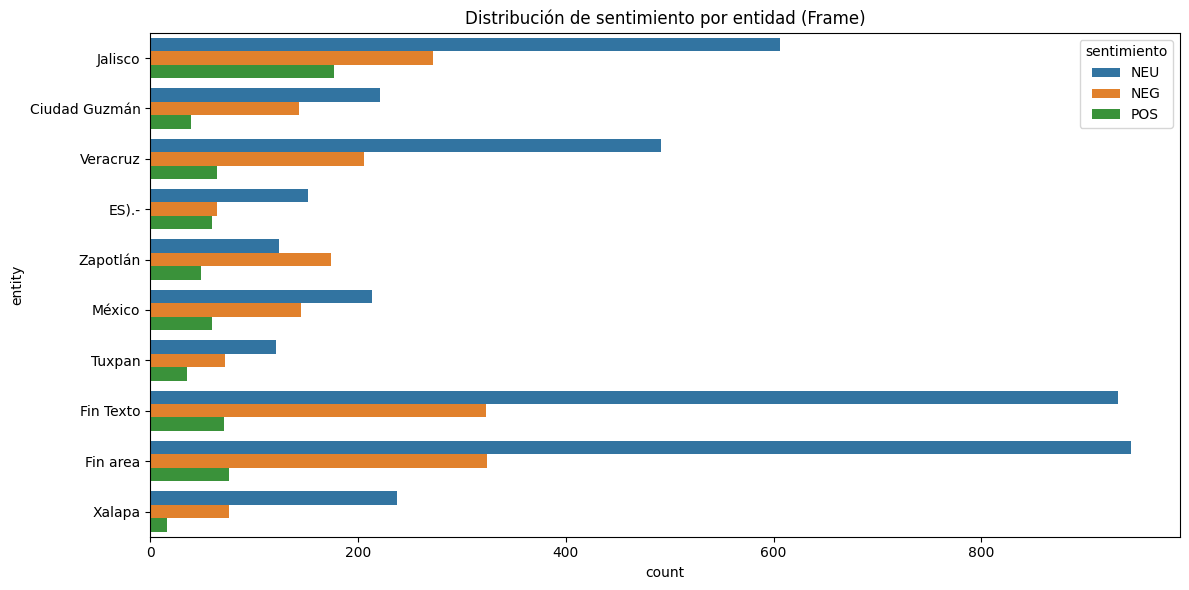

In [ ]:
# Análisis de sentimiento por frame
# Crear un dataframe expandido con una fila por entidad
entity_rows = []
for idx, row in df.iterrows():
    for entity in row['entities']:
        entity_rows.append({
            'entity': entity,
            'sentimiento': row['sentimiento'],
            'titulo': row['titulo']
        })
entity_df = pd.DataFrame(entity_rows)

# Analizar distribución de sentimiento por entidad
top_entities = [ent[0] for ent in entity_counts[:10]]
filtered_df = entity_df[entity_df['entity'].isin(top_entities)]

plt.figure(figsize=(12,6))
sns.countplot(data=filtered_df, y='entity', hue='sentimiento')
plt.title("Distribución de sentimiento por entidad (Frame)")
plt.tight_layout()
plt.show()

In [ ]:
entity_df

,entity,sentimiento,titulo
0,UEPCBJ,NEU,Dan Banderazo de Arranque al Operativo de Sema...
1,Puesto de Comando Central,NEU,Dan Banderazo de Arranque al Operativo de Sema...
2,Jalisco,NEU,Dan Banderazo de Arranque al Operativo de Sema...
3,Gobierno del Estado,NEU,Dan Banderazo de Arranque al Operativo de Sema...
4,Operativo Interinstitucional,NEU,Dan Banderazo de Arranque al Operativo de Sema...
...,...,...,...
71820,Coparmex,NaN,Coparmex dice no estar de acuerdo que gobierno...
71821,López Obrador,NaN,Coparmex dice no estar de acuerdo que gobierno...
71822,Realmente,NaN,Coparmex dice no estar de acuerdo que gobierno...
71823,López Obrador,NaN,Coparmex dice no estar de acuerdo que gobierno...


In [ ]:
entity_df.to_csv('sentimientos_por_entidad.csv', index=False, encoding='utf-8-sig')

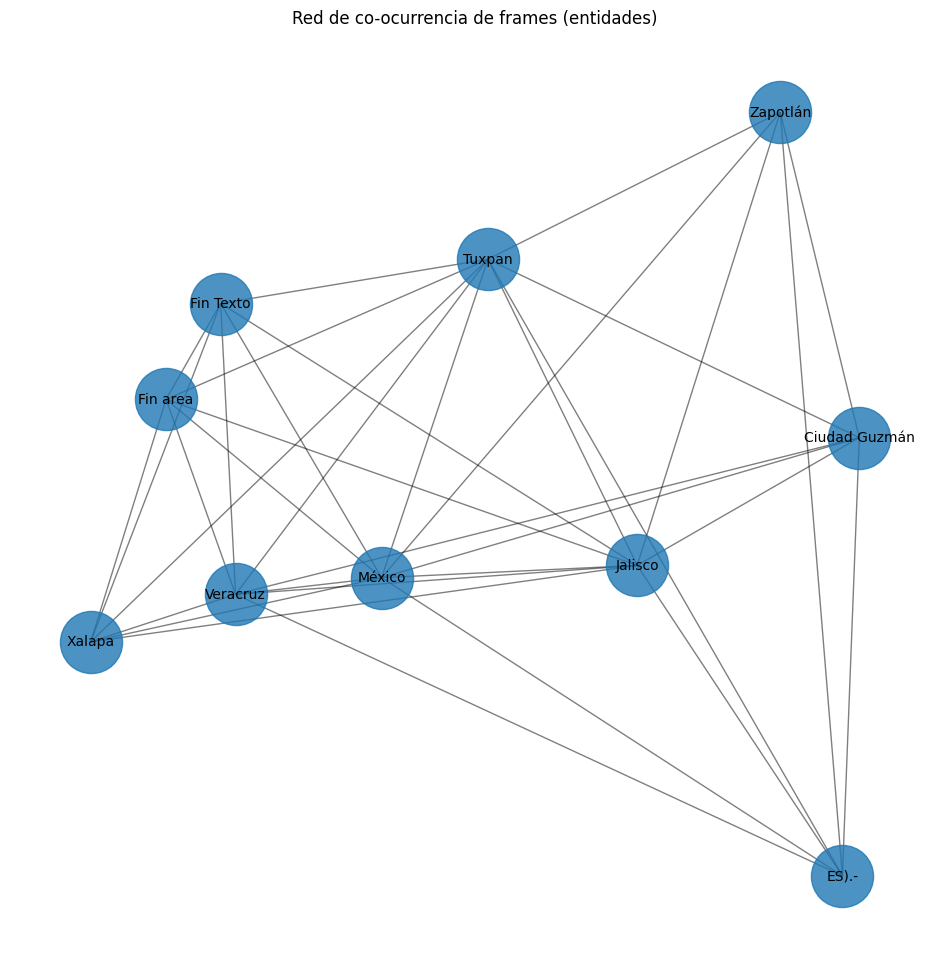

In [ ]:
# Análisis de redes semánticas
import networkx as nx

# Crear co-ocurrencia de entidades
co_occur = pd.DataFrame(index=top_entities, columns=top_entities, data=0)

for entities in df['entities']:
    for i in range(len(entities)):
        for j in range(i+1, len(entities)):
            if entities[i] in top_entities and entities[j] in top_entities:
                co_occur.loc[entities[i], entities[j]] += 1
                co_occur.loc[entities[j], entities[i]] += 1

# Crear gráfico de red
G = nx.Graph()
for entity in top_entities:
    G.add_node(entity)
    
for i in range(len(top_entities)):
    for j in range(i+1, len(top_entities)):
        if co_occur.iloc[i,j] > 0:
            G.add_edge(top_entities[i], top_entities[j], weight=co_occur.iloc[i,j])

# Dibujar red
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=2000, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Red de co-ocurrencia de frames (entidades)")
plt.axis('off')
plt.show()

In [ ]:
# Análisis diacrónico de frames para ver cómo evolucionan en el tiempo
# Convertir fecha a datetime (asumiendo que existe una columna fecha)
df['fecha'] = pd.to_datetime(df['fecha'])

# Extraer mes y año
df['mes_año'] = df['fecha'].dt.to_period('M')

# Contar frames por periodo temporal
frames_over_time = df.explode('entities').groupby(['mes_año', 'entities'])['titulo'].count().unstack().fillna(0)

# Visualizar frames más importantes
top_frames = frames_over_time.sum().sort_values(ascending=False).head(5).index
frames_over_time[top_frames].plot(figsize=(12,6))
plt.title("Evolución temporal de frames principales")
plt.ylabel("Frecuencia")
plt.xlabel("Tiempo")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1253/4254586063.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['fecha'] = pd.to_datetime(df['fecha'])


DateParseError: Unknown datetime string format, unable to parse: abril 12th, 2025, at position 0

In [ ]:
# Análisis comparativo entre medios
# Asumiendo que tienes una columna 'medio' que identifica cada fuente
# Si no, necesitarías combinar tus 4 bases de datos primero

def compare_frames_across_media(df, frame_type='entities'):
    if frame_type == 'entities':
        extract_func = extract_entities
    else:
        extract_func = extract_keywords
    
    comparison = df.explode(frame_type).groupby(['medio', frame_type]).size().unstack().fillna(0)
    
    # Normalizar por número de artículos por medio
    articles_per_medium = df['medio'].value_counts()
    comparison = comparison.div(articles_per_medium, axis=0)
    
    # Tomar los 5 frames más distintivos por medio
    top_frames = {}
    for medium in comparison.index:
        top_frames[medium] = comparison.loc[medium].sort_values(ascending=False).head(5).index.tolist()
    
    return top_frames

# Ejemplo de uso (necesitarías tener la columna 'medio')
frame_comparison = compare_frames_across_media(df)
print(frame_comparison)

{'Al Calor Político': ['Fin area', 'Fin Texto', 'Veracruz', 'Xalapa', 'México'], 'La Voz del Sur': ['Jalisco', 'Ciudad Guzmán', 'Zapotlán', 'ES).-', 'Instituto Jalisciense de Ciencias Forenses'], 'Letra Fría': ['Jalisco', 'Tecolotlán', 'El Grullo', 'El Limón', 'Cihuatlán'], 'Plumas Libres': ['Veracruz', 'Xalapa', 'México', 'Orizaba', 'Ver.-']}


In [ ]:
frame_comparison

{'Al Calor Político': ['Fin area',
  'Fin Texto',
  'Veracruz',
  'Xalapa',
  'México'],
 'La Voz del Sur': ['Jalisco',
  'Ciudad Guzmán',
  'Zapotlán',
  'ES).-',
  'Instituto Jalisciense de Ciencias Forenses'],
 'Letra Fría': ['Jalisco', 'Tecolotlán', 'El Grullo', 'El Limón', 'Cihuatlán'],
 'Plumas Libres': ['Veracruz', 'Xalapa', 'México', 'Orizaba', 'Ver.-']}

In [ ]:
frame_comparison.to_csv('frame_comparison.csv', index=False, encoding='utf-8-sig')

AttributeError: 'dict' object has no attribute 'to_csv'